c:\Users\Thania\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


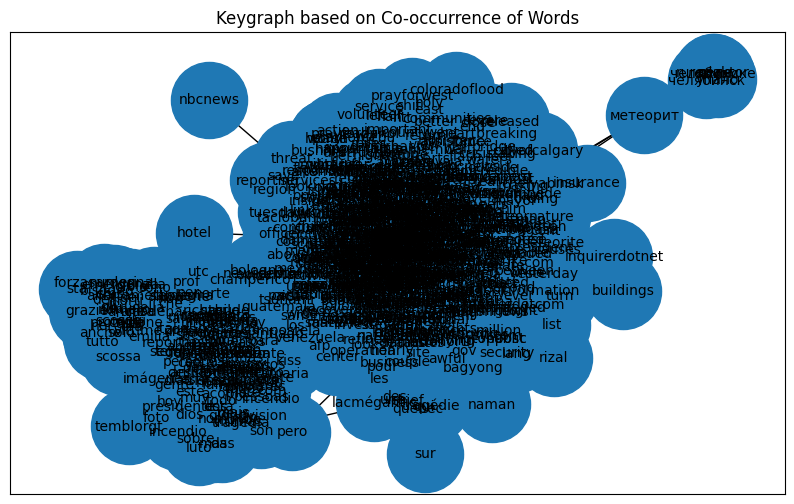

Number of Connected Components: 1
Density: 0.028996932804548035
Average Degree: 28.93893893893894


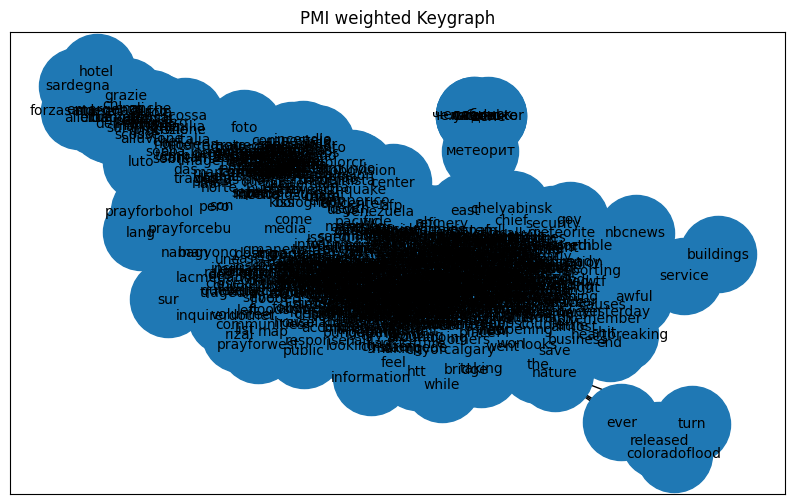

Number of Connected Components: 1
Density: 0.028996932804548035
Average Degree: 28.93893893893894


In [13]:
import os
import json
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import re


def custom_tokenizer(text):
    # Tokenize using CountVectorizer's built-in tokenizer
    standard_tokenizer = CountVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    
    # Filter out unwanted tokens
    filtered_tokens = [
        token for token in tokens 
        if not token.lower().startswith('http') 
        and len(token) >= 3 
        and not bool(re.search(r'\d', token))
    ]
    return filtered_tokens


def apply_keygraph(text_data, min_co_occurrence=5):
    vectorizer = CountVectorizer(tokenizer=custom_tokenizer, min_df=5, max_features=1000)
    term_document_matrix = vectorizer.fit_transform(text_data)
    features = vectorizer.get_feature_names_out()
    
    co_occurrence_graph = nx.Graph()

    # Get term co-occurrences
    co_occurrences = (term_document_matrix.T @ term_document_matrix).tocoo()

    # Only add edges with significant weight
    coords = zip(co_occurrences.row, co_occurrences.col, co_occurrences.data)
    for i, j, w in coords:
        if i != j and w >= min_co_occurrence:
            co_occurrence_graph.add_edge(features[i], features[j], weight=w)
                
    return co_occurrence_graph, term_document_matrix, features

all_text_data = []
base_directory = "CrisisLexT26-v1.0\CrisisLexT26"

for folder_name in os.listdir(base_directory):
    folder_path = os.path.join(base_directory, folder_name)
    if os.path.isdir(folder_path):
        tweets_csv_path = os.path.join(folder_path, f"{folder_name}-tweets_labeled.csv")
        
        df = pd.read_csv(tweets_csv_path)
        df = df[df[' Informativeness'].isin(['Related - but not informative', 'Related and informative'])]
        text_data = df[' Tweet Text'].values
        all_text_data.extend(text_data)

SAMPLE_SIZE = 10000  # Adjust as needed
sample_indices = np.random.choice(len(all_text_data), SAMPLE_SIZE, replace=True)
sampled_text_data = [all_text_data[i] for i in sample_indices]

G, term_document_matrix, features = apply_keygraph(sampled_text_data)


def graph_metrics(G):
    n_connected_components = nx.number_connected_components(G)
    density = nx.density(G)
    avg_degree = sum(dict(G.degree()).values()) / len(G)

    return {
        "Number of Connected Components": n_connected_components,
        "Density": density,
        "Average Degree": avg_degree
    }

metrics = graph_metrics(G)
for metric, value in metrics.items():
    print(f"{metric}: {value}")

def compute_pmi(G, term_document_matrix, features):
    n_docs = term_document_matrix.shape[0]
    word_counts = np.sum(term_document_matrix, axis=0)
    total_co_occurrences = np.sum(term_document_matrix.T @ term_document_matrix)

    for edge in G.edges():
        word1, word2 = edge
        i, j = np.where(features == word1)[0][0], np.where(features == word2)[0][0]
        co_occurrence = (term_document_matrix.T @ term_document_matrix)[i, j].item()

        pmi = np.log2((co_occurrence * n_docs) / (word_counts[0, i] * word_counts[0, j]))

        # Update edge weight with PMI
        G[word1][word2]['weight'] = pmi

    return G

G_pmi = compute_pmi(G, term_document_matrix, features)

# Visualizing G_pmi
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G_pmi)
nx.draw_networkx_nodes(G_pmi, pos, node_size=3000)
nx.draw_networkx_edges(G_pmi, pos)
nx.draw_networkx_labels(G_pmi, pos, font_size=10)
plt.title("PMI weighted Keygraph")
plt.show()

# Metrics for G_pmi
metrics_pmi = graph_metrics(G_pmi)
for metric, value in metrics_pmi.items():
    print(f"{metric}: {value}")


C:\Users\Thania\AppData\Local\Temp\ipykernel_2244\1686452187.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


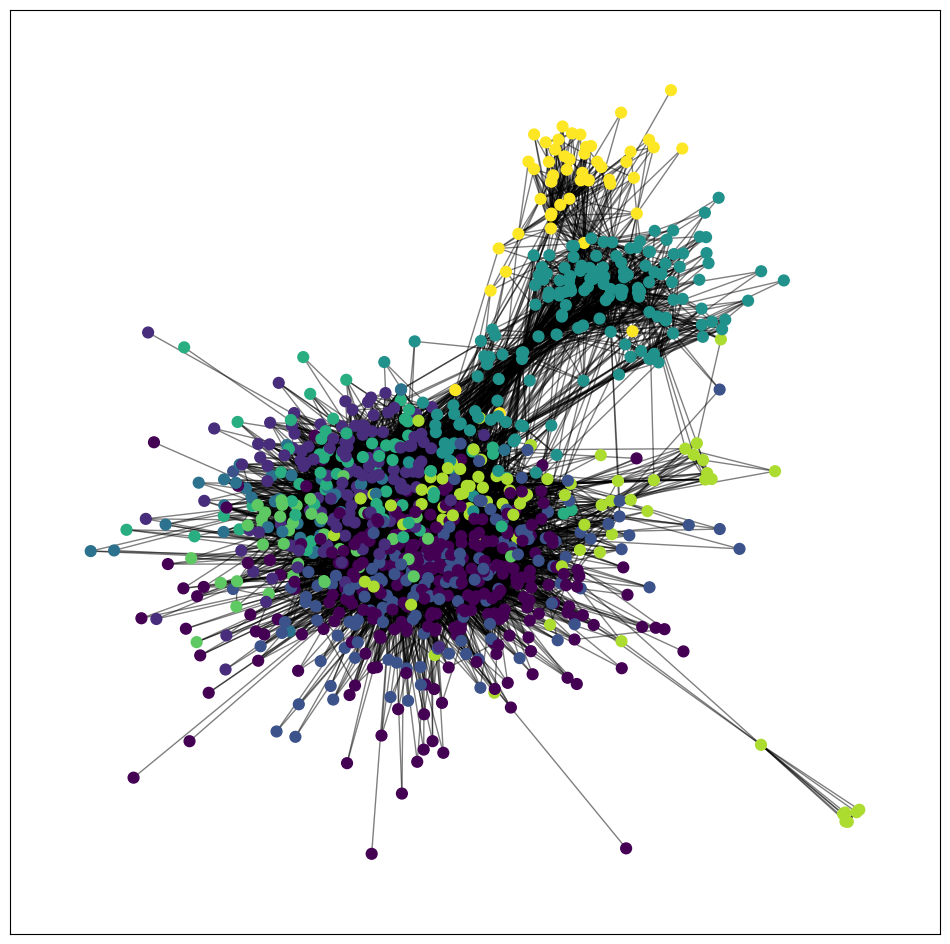

Community 1:
fire, out, the, for, are, please, today, relief, now, volunteers, our, you, with, this, all, help, about, good, have, info, not, need, amp, water, many, and, its, those, day, stay, their, that, read, think, how, don, know, boulderflood, still, thoughts, your, lost, safe, care, been, why, families, what, heard, hope, just, philippines, safety, down, praying, tragedy, such, brazil, nightclub, sad, ddlovato, hear, there, affected, everyone, miles, rescueph, yolandaph, victims, tragic, other, sending, let, red, anyone, even, terrible, tonight, them, will, can, goes, heart, donations, but, prayers, pray, prayforvisayas, bless, god, were, haiyan, typhoon, who, donate, want, cebu, aid, home, back, hospital, they, rescuers, died, under, church, bohol, super, online, some, aftermath, again, never, right, see, southern, prayer, rip, visayas, friends, every, thanks, these, scary, concerns, amazing, thank, highparkfire, due, mindanao, join, especially, feel, children, helping, needs, 

In [24]:
import community as community_louvain
import matplotlib.cm as cm

def detect_communities(G):
 
    # Create a copy of the graph
    G_copy = G.copy()
    
    # Remove edges with negative weights
    negative_edges = [(u, v) for u, v, d in G_copy.edges(data=True) if d['weight'] < 0]
    G_copy.remove_edges_from(negative_edges)
    
    # Compute the best partition
    partition = community_louvain.best_partition(G_copy)
    
    # Visualize the communities
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G_copy)
    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    
    nx.draw_networkx_nodes(G_copy, pos, partition.keys(), node_size=60, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G_copy, pos, alpha=0.5)
    
    plt.show()
    
    return partition


communities = detect_communities(G_pmi)

# Print the communities
for i, com in enumerate(set(communities.values())):
    print(f"Community {i + 1}:")
    nodes = [nodes for nodes in communities.keys() if communities[nodes] == com]
    print(", ".join(nodes))
    print("")
